In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# Video segmentation with SAM 2

This notebook shows how to use SAM 2 for interactive segmentation in videos. It will cover the following:

- adding clicks (or box) on a frame to get and refine _masklets_ (spatio-temporal masks)
- propagating clicks (or box) to get _masklets_ throughout the video
- segmenting and tracking multiple objects at the same time

We use the terms _segment_ or _mask_ to refer to the model prediction for an object on a single frame, and _masklet_ to refer to the spatio-temporal masks across the entire video.

<a target="_blank" href="https://colab.research.google.com/github/facebookresearch/sam2/blob/main/notebooks/video_predictor_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## 1. Environment Set-up

If running locally using jupyter, first install `sam2` in your environment using the [installation instructions](https://github.com/facebookresearch/sam2#installation) in the repository.

If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'. Note that it's recommended to use **A100 or L4 GPUs when running in Colab** (T4 GPUs might also work, but could be slow and might run out of memory in some cases).

In [2]:
using_colab = False

In [3]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/sam2.git'

    !mkdir -p videos
    !wget -P videos https://dl.fbaipublicfiles.com/segment_anything_2/assets/bedroom.zip
    !unzip -d videos videos/bedroom.zip

    !mkdir -p ../checkpoints/
    !wget -P ../checkpoints/ https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_large.pt

## Set-up

In [4]:
import os
# UNCOMMENT THE FOLLOWING LINE ON MAC (if using Apple MPS, fall back to CPU for unsupported ops)
# os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import torchaudio as T
import torchaudio.transforms as TT
from diffwave.inference import predict as diffwave_predict
from diffwave.params import params
import librosa.display


In [5]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


## 2. Creating a spectrogram from an audio file
### There is no need to run this section if the files are already saved on the computer.
We will define a function that converts an audio file to spectrogram files and spectrogram images

In [6]:
def input2mel(filename, output_dir):
    # Load the original audio file
    audio, sr = T.load(filename)  # Load audio and sample rate using torchaudio

    # Check if resampling is needed
    if sr != params.sample_rate:
        resampler = TT.Resample(orig_freq=sr, new_freq=params.sample_rate)
        audio = resampler(audio)
        sr = params.sample_rate

    # Check if reformating is needed
    if audio.type() != torch.int16:
        # Convert the audio to 16-bit PCM format
        audio = (audio * 32767).to(torch.int16)

    audio = torch.clamp(audio[0] / 32767.5, -1.0, 1.0)

    window_size = params.hop_samples * 4     
    overlap = params.hop_samples        
    nfft = params.n_fft  

    mel_args = {
        'sample_rate': sr,
        'win_length': window_size, 
        'hop_length': overlap,   
        'n_fft': nfft,
        'f_min': 20.0,
        'f_max': sr / 2.0,
        'n_mels': params.n_mels,
        'power': 1.0,
        'normalized': True,
    }
    mel_spec_transform = TT.MelSpectrogram(**mel_args)

    # Calculate the total number of X-second chunks - for better interpretability
    chunk_duration = 1  # Duration in seconds
    chunk_samples = chunk_duration * sr
    total_chunks = int(np.ceil(len(audio) / chunk_samples))

    for chunk_idx in range(total_chunks):
        # Extract the current segment
         # Extract the current chunk
        start_sample = chunk_idx * chunk_samples
        end_sample = min((chunk_idx + 1) * chunk_samples, len(audio))
        chunk = audio[start_sample:end_sample]

        # Pad the last chunk if it's less than X seconds
        if len(chunk) < chunk_samples:
            chunk = torch.cat((chunk, torch.zeros(chunk_samples - len(chunk))))


        # Compute the spectrogram
        with torch.no_grad():
            spectrogram = mel_spec_transform(chunk)
            spectrogram = 20 * torch.log10(torch.clamp(spectrogram, min=1e-5)) - 20
            spectrogram = torch.clamp((spectrogram + 100) / 100, 0.0, 1.0)

        # Plot the spectrogram using librosa
        plt.rcParams['figure.dpi'] = 600
        fig = plt.figure(figsize=(8,8))  # 1024x1024 pixels at 300 DPI
        ax = plt.Axes(fig, [0., 0., 1., 1.])  # Remove margins for full screen
        fig.add_axes(ax)
        ax.axis("off")

        librosa.display.specshow(
            spectrogram.numpy(),
            sr=sr,
            hop_length=overlap,
            x_axis="time",
            y_axis="mel",
            cmap="magma",  # Can try also 'jet'
        )

        output_dir_img = output_dir + "_images"
        output_dir_spec = output_dir + "_np_array"
        os.makedirs(output_dir_spec, exist_ok=True)
        os.makedirs(output_dir_img, exist_ok=True)

        # Save the spectrogram image
        output_path_img = os.path.join(output_dir_img, f'{chunk_idx:04d}.jpg')
        fig.savefig(output_path_img, bbox_inches='tight', pad_inches=0)
        plt.close(fig)

        # Save the original spectrogram data
        output_path_spec = os.path.join(output_dir_spec, f'{chunk_idx:04d}.npy')
        np.save(output_path_spec, spectrogram.numpy()) # The spectrogram is a numpy array
    return sr, overlap



Upload an audio file and create a spectrogram:

In [7]:
# Audio file path
audio_path = r'female_speech.WAV'  # Replace with your audio file path
# Output directory for images and spectogram
output_dir = 'spectrogram'  # Replace with your audio file path
sr, overlap = input2mel(audio_path, output_dir)


## 3. Segmentation using SAM2
### Loading the SAM 2 video predictor

In [8]:
from sam2.build_sam import build_sam2_video_predictor
import os
print(os.getcwd())

sam2_checkpoint = "checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

c:\Users\orita\dev\sam2


In [9]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

#### Upload the spectrogram images

We will upload one picture to make sure everything is correct

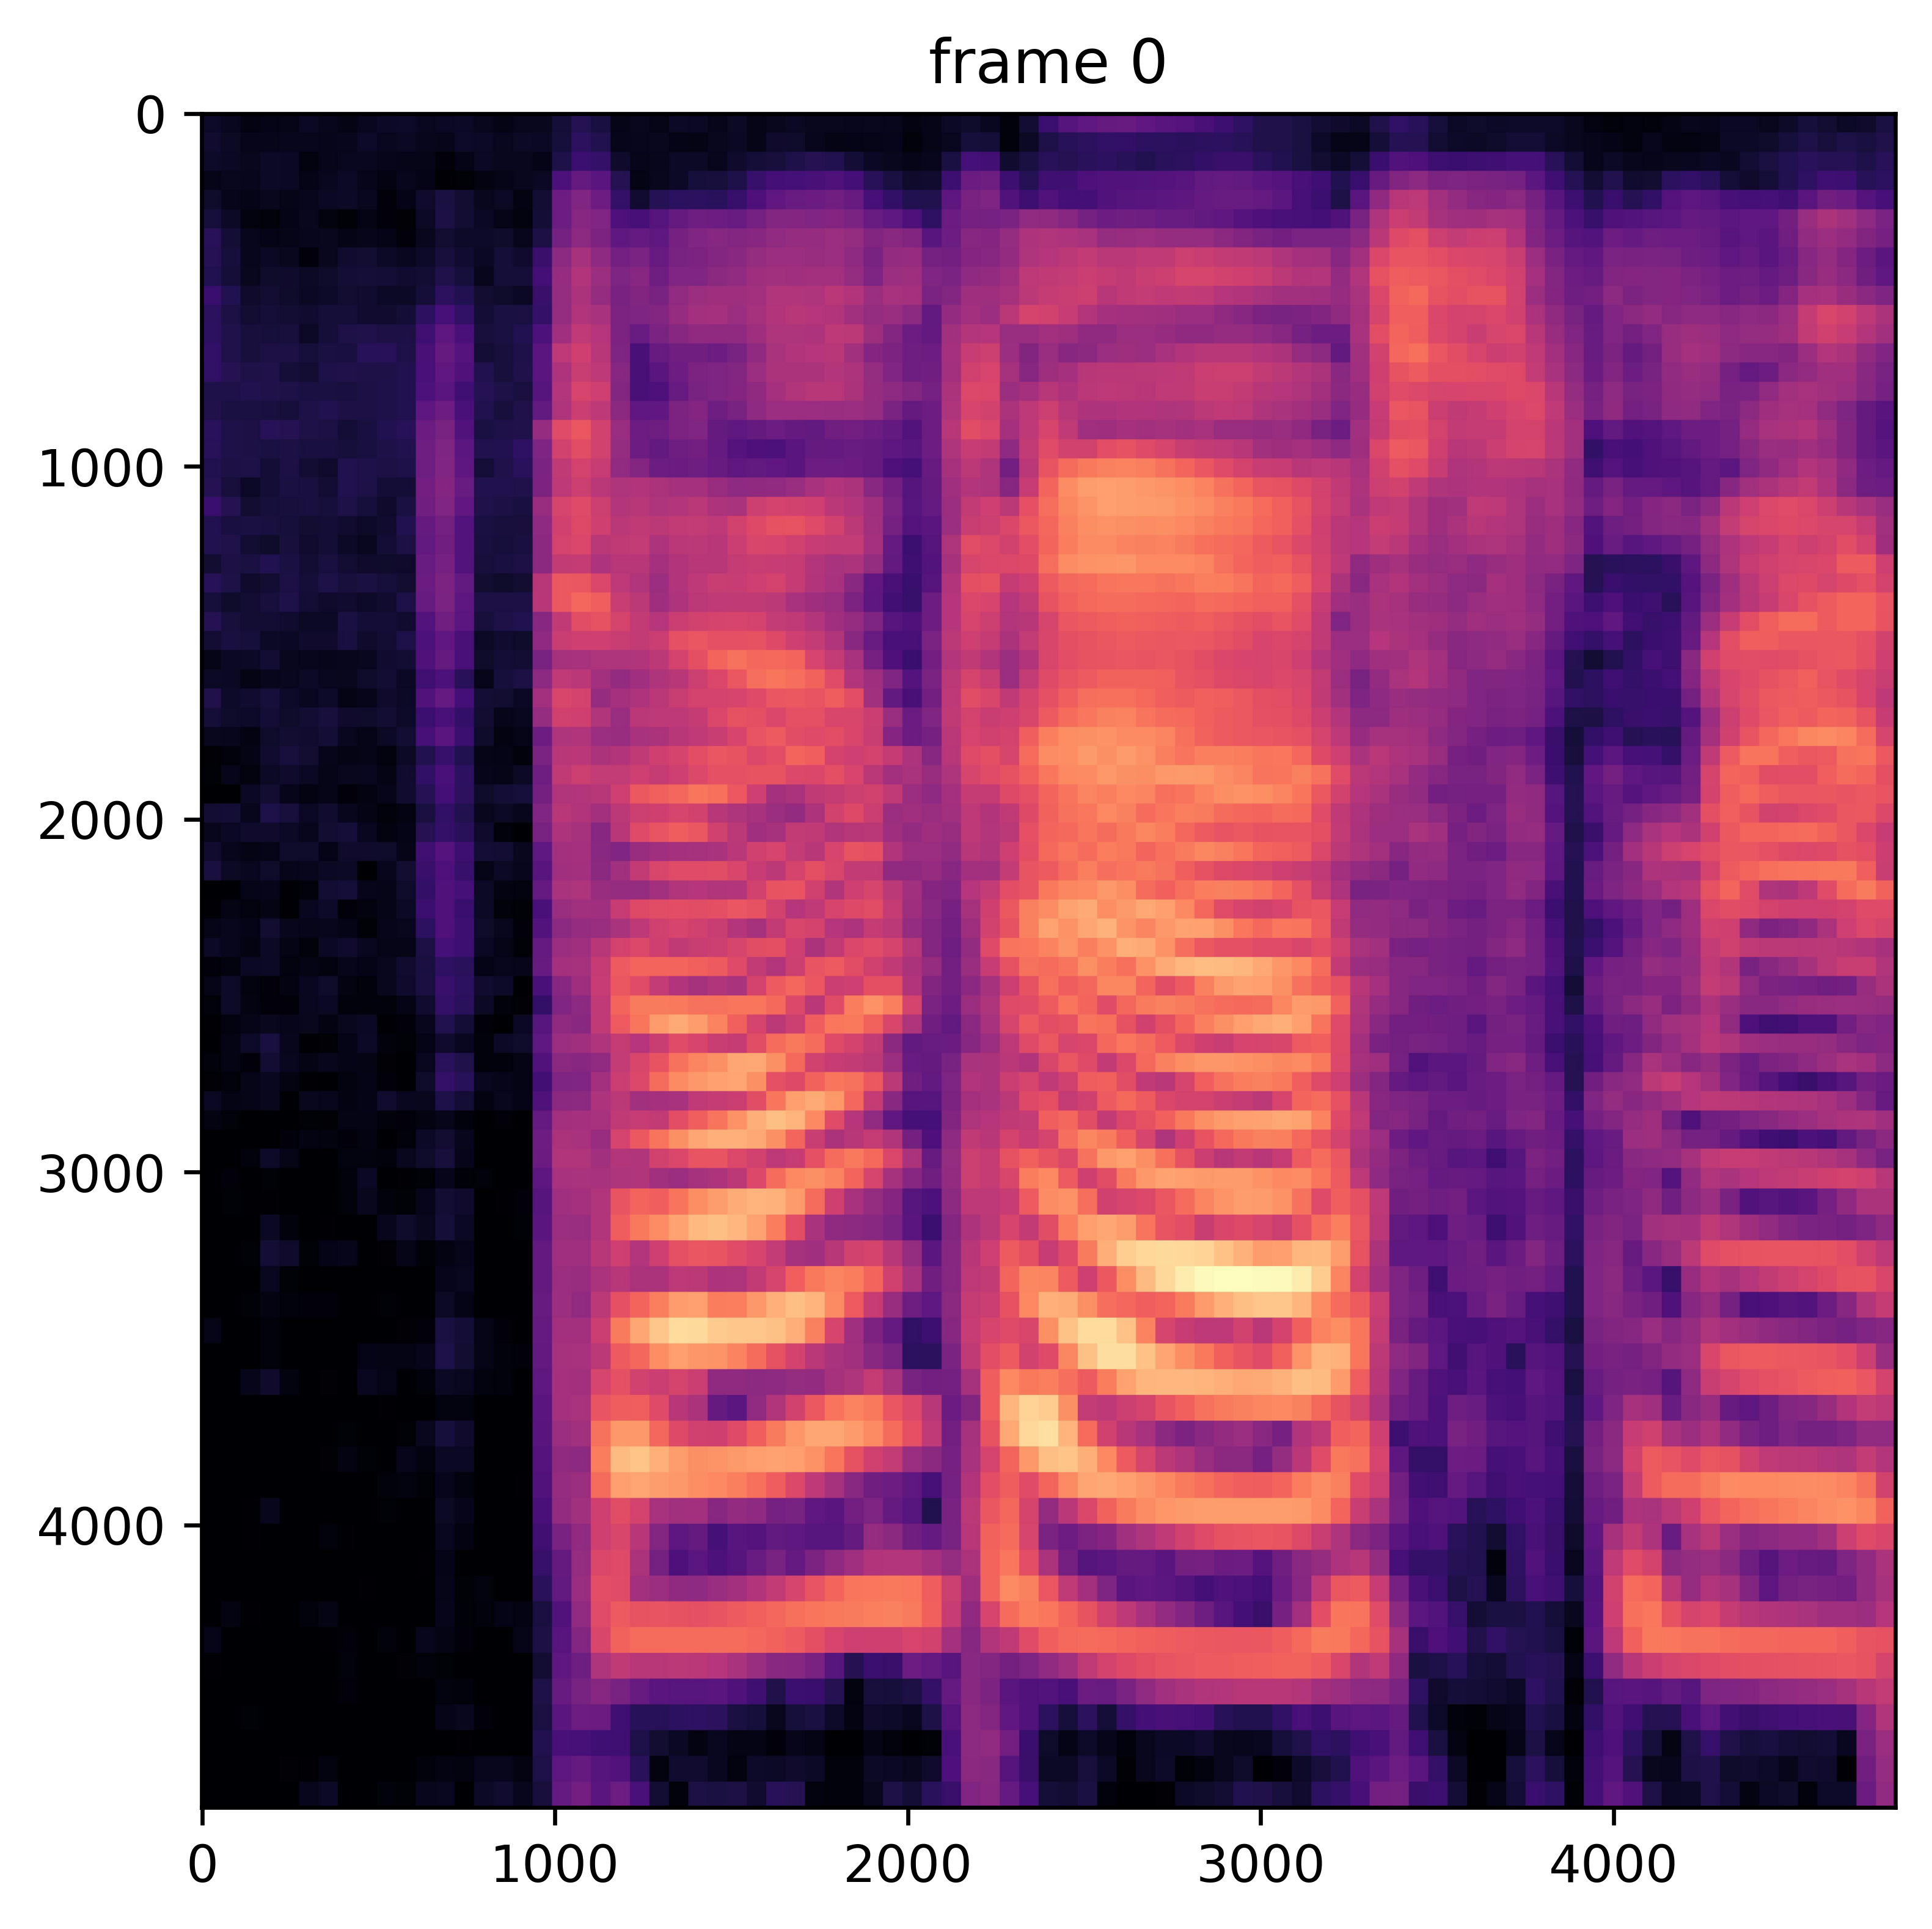

In [10]:
# `video_dir` a directory of JPEG frames with filenames like `<frame_index>.jpg`
video_dir = "./spectrogram_images" # Replace with your spectograma file path

# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

# take a look the first video frame
frame_idx = 0
plt.figure(figsize=(9, 6))
plt.title(f"frame {frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[frame_idx])))

#### Initialize the inference state

SAM 2 requires stateful inference for interactive video segmentation, so we need to initialize an **inference state** on this video.

During initialization, it loads all the JPEG frames in `video_path` and stores their pixels in `inference_state` (as shown in the progress bar below).

In [11]:
inference_state = predictor.init_state(video_path=video_dir)

frame loading (JPEG):   0%|          | 0/4 [00:00<?, ?it/s]

frame loading (JPEG): 100%|██████████| 4/4 [00:00<00:00,  4.70it/s]


Note: if you have run any previous tracking using this `inference_state`, please reset it first via `reset_state`.

(The cell below is just for illustration; it's not needed to call `reset_state` here as this `inference_state` is just freshly initialized above.)

In [12]:
predictor.reset_state(inference_state)

### Segment multiple objects simultaneously

In [13]:
from clicker import collect_clicks

prompts = {}  # hold all the clicks we add for visualization
ann_frame_idx = 0  # the frame index we interact with\

img_path = os.path.join(video_dir, frame_names[ann_frame_idx])

points_list, labels = collect_clicks(img_path)

assert len(points_list) == len(labels), "Number of points and labels should be the same"

num_of_promt = len(points_list)



#### Step 1: Add clicks

c:\Users\orita\dev\sam2\sam2\sam2_video_predictor.py:786: UserWarning: cannot import name '_C' from 'sam2' (c:\Users\orita\dev\sam2\sam2\__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(


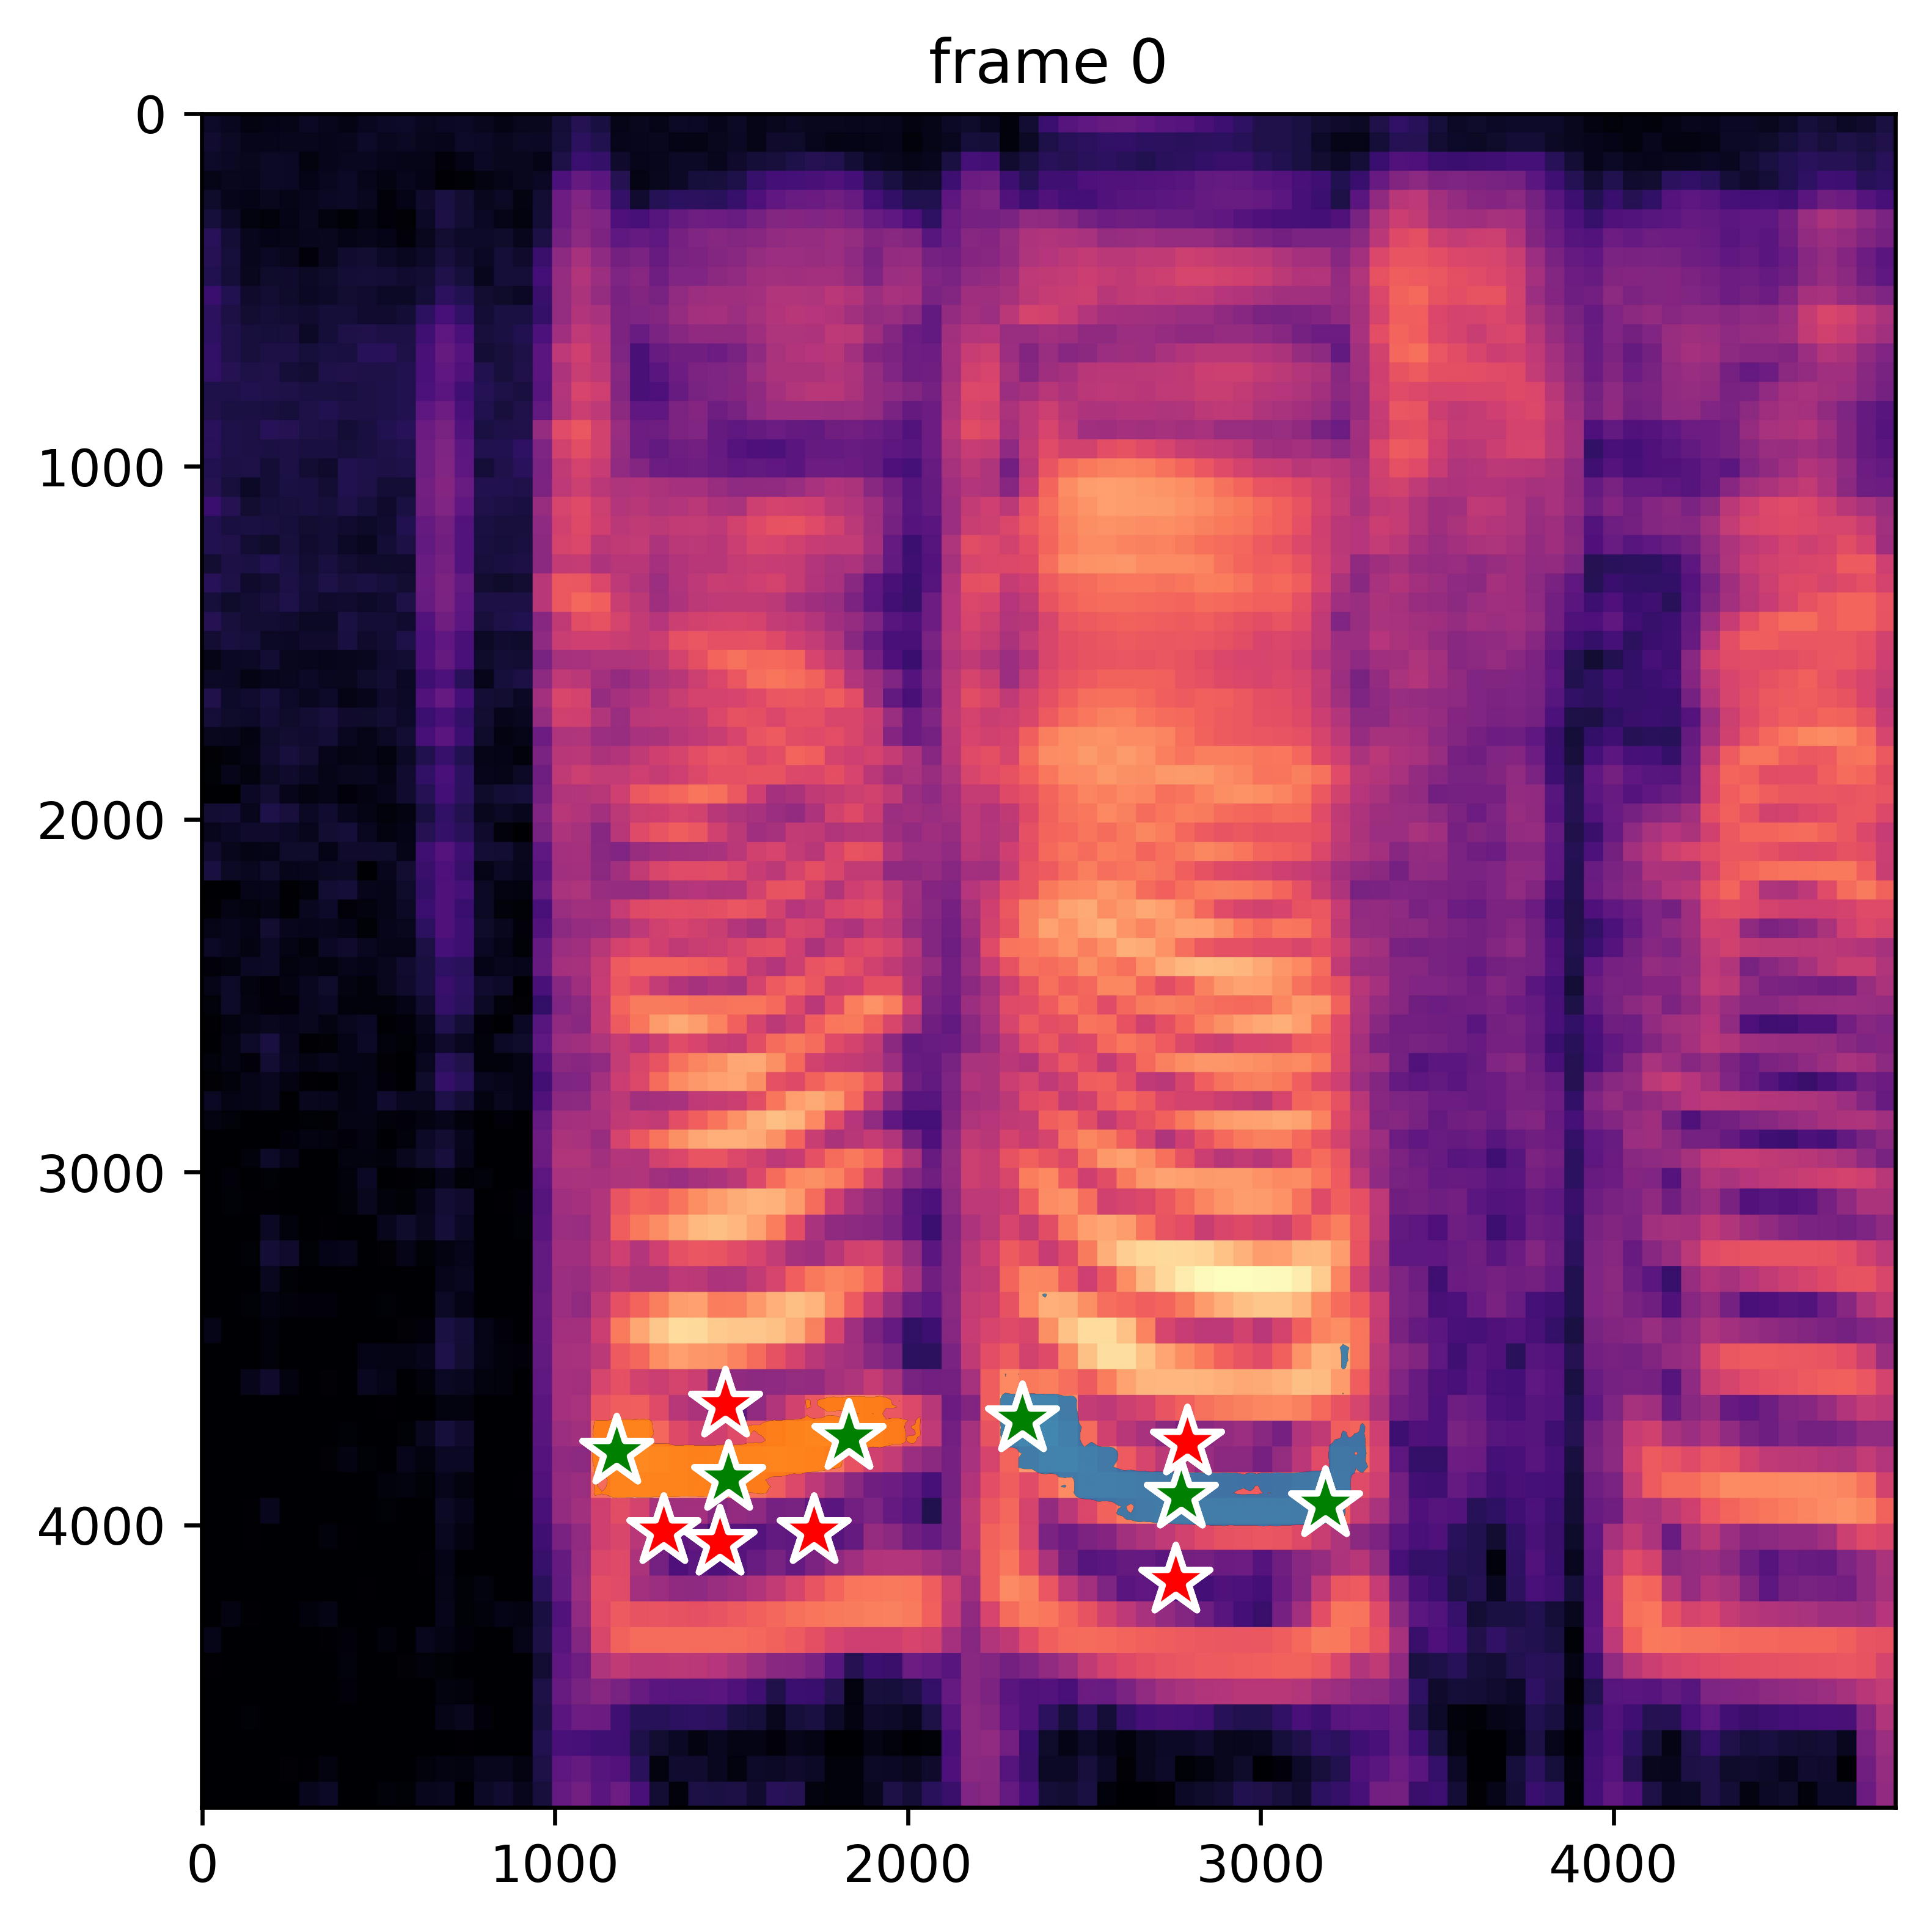

In [14]:


# # sending all clicks (and their labels) to `add_new_points_or_box`
# #points_list = [np.array([[600, 170], [275, 800]], dtype=np.float32)] # Exempale
# points_list = [np.array([[800, 2100]], dtype=np.float32), np.array([[1500, 2120]], dtype=np.float32)] #TODO: add clicks
# num_of_promt = len(points_list)

# # for labels, `1` means positive click and `0` means negative click
# #labels = [np.array([1, 0], np.int32),np.array([1], np.int32)] # Exempale
# labels = [np.array([1], np.int32),np.array([1], np.int32)] #TODO: add labels

for i in range(num_of_promt):
    prompts[i] = points_list[i], labels[i]
    _, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
        inference_state=inference_state,
        frame_idx=0,
        obj_id=i,
        points=points_list[i],
        labels=labels[i],
)

# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
for i in range(num_of_promt):
    show_points(points_list[i], labels[i], plt.gca())
    for i, out_obj_id in enumerate(out_obj_ids):
        show_points(*prompts[i], plt.gca())
        show_mask((out_mask_logits[i] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_id)

#### Step 2: Propagate the prompts to get masklets across the video

Now, we propagate the prompts for both objects to get their masklets throughout the video.

Note: when there are multiple objects, the `propagate_in_video` API will return a list of masks for each object.

propagate in video: 100%|██████████| 4/4 [00:01<00:00,  3.80it/s]


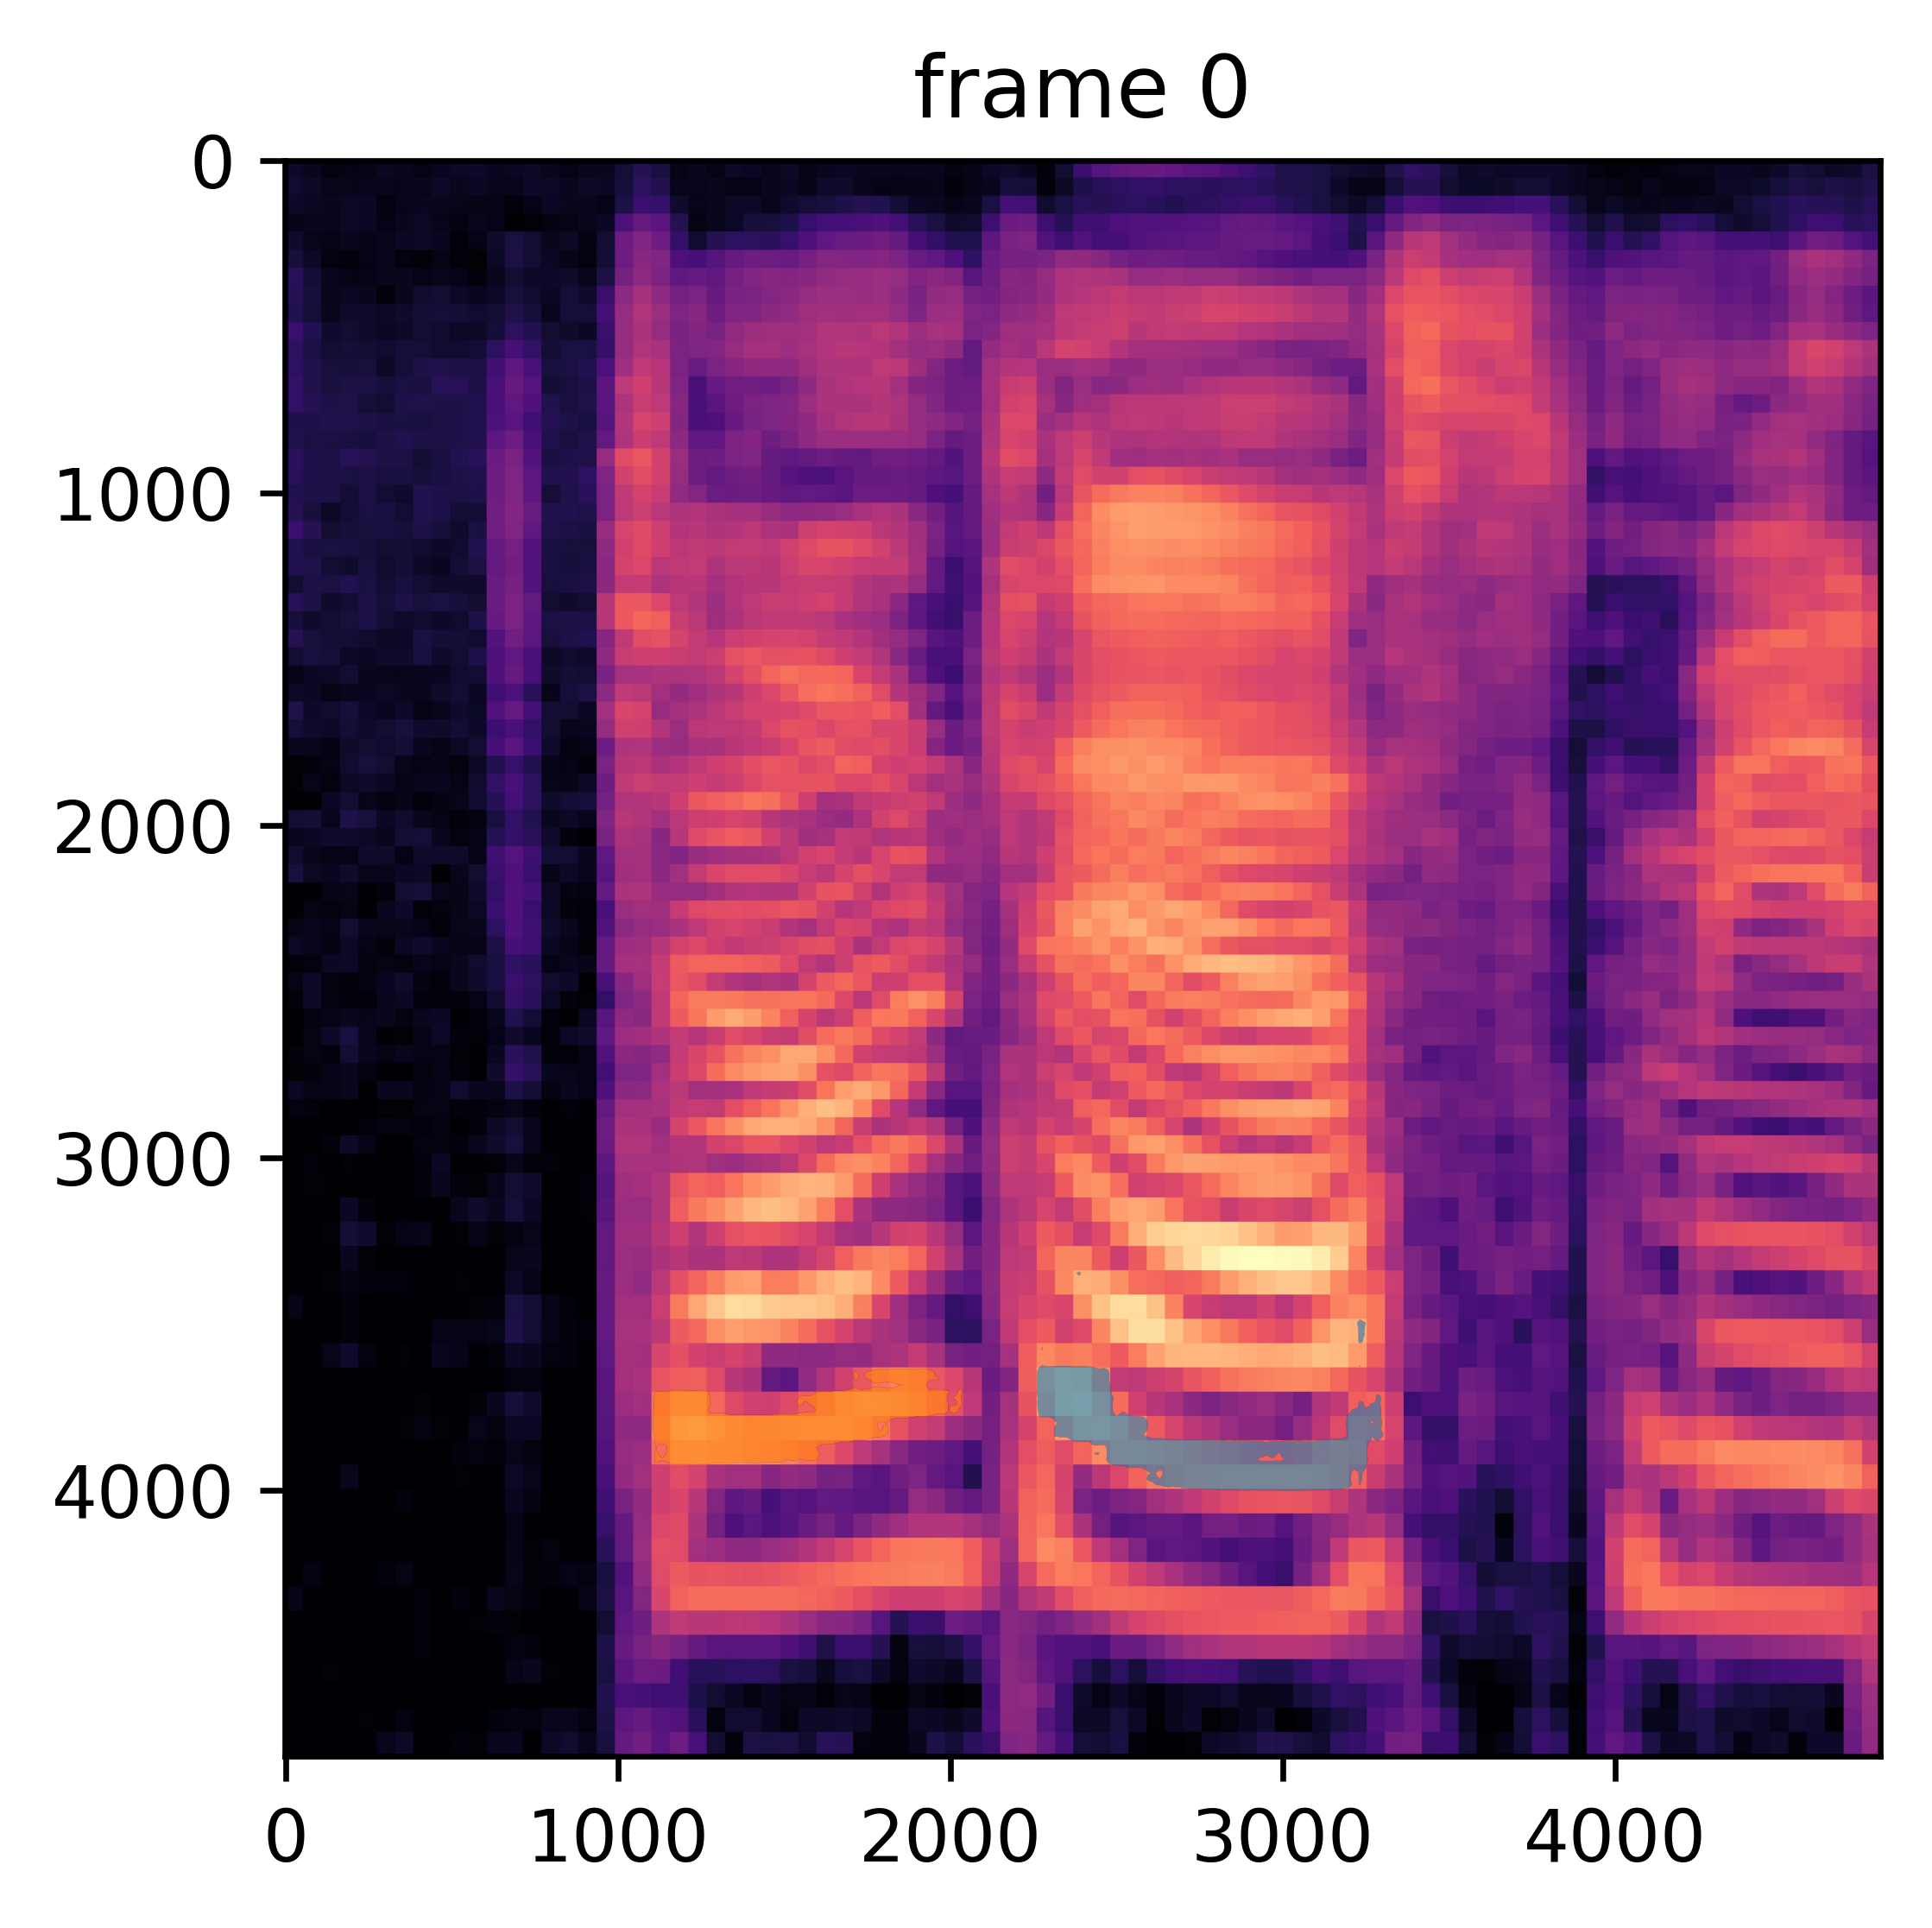

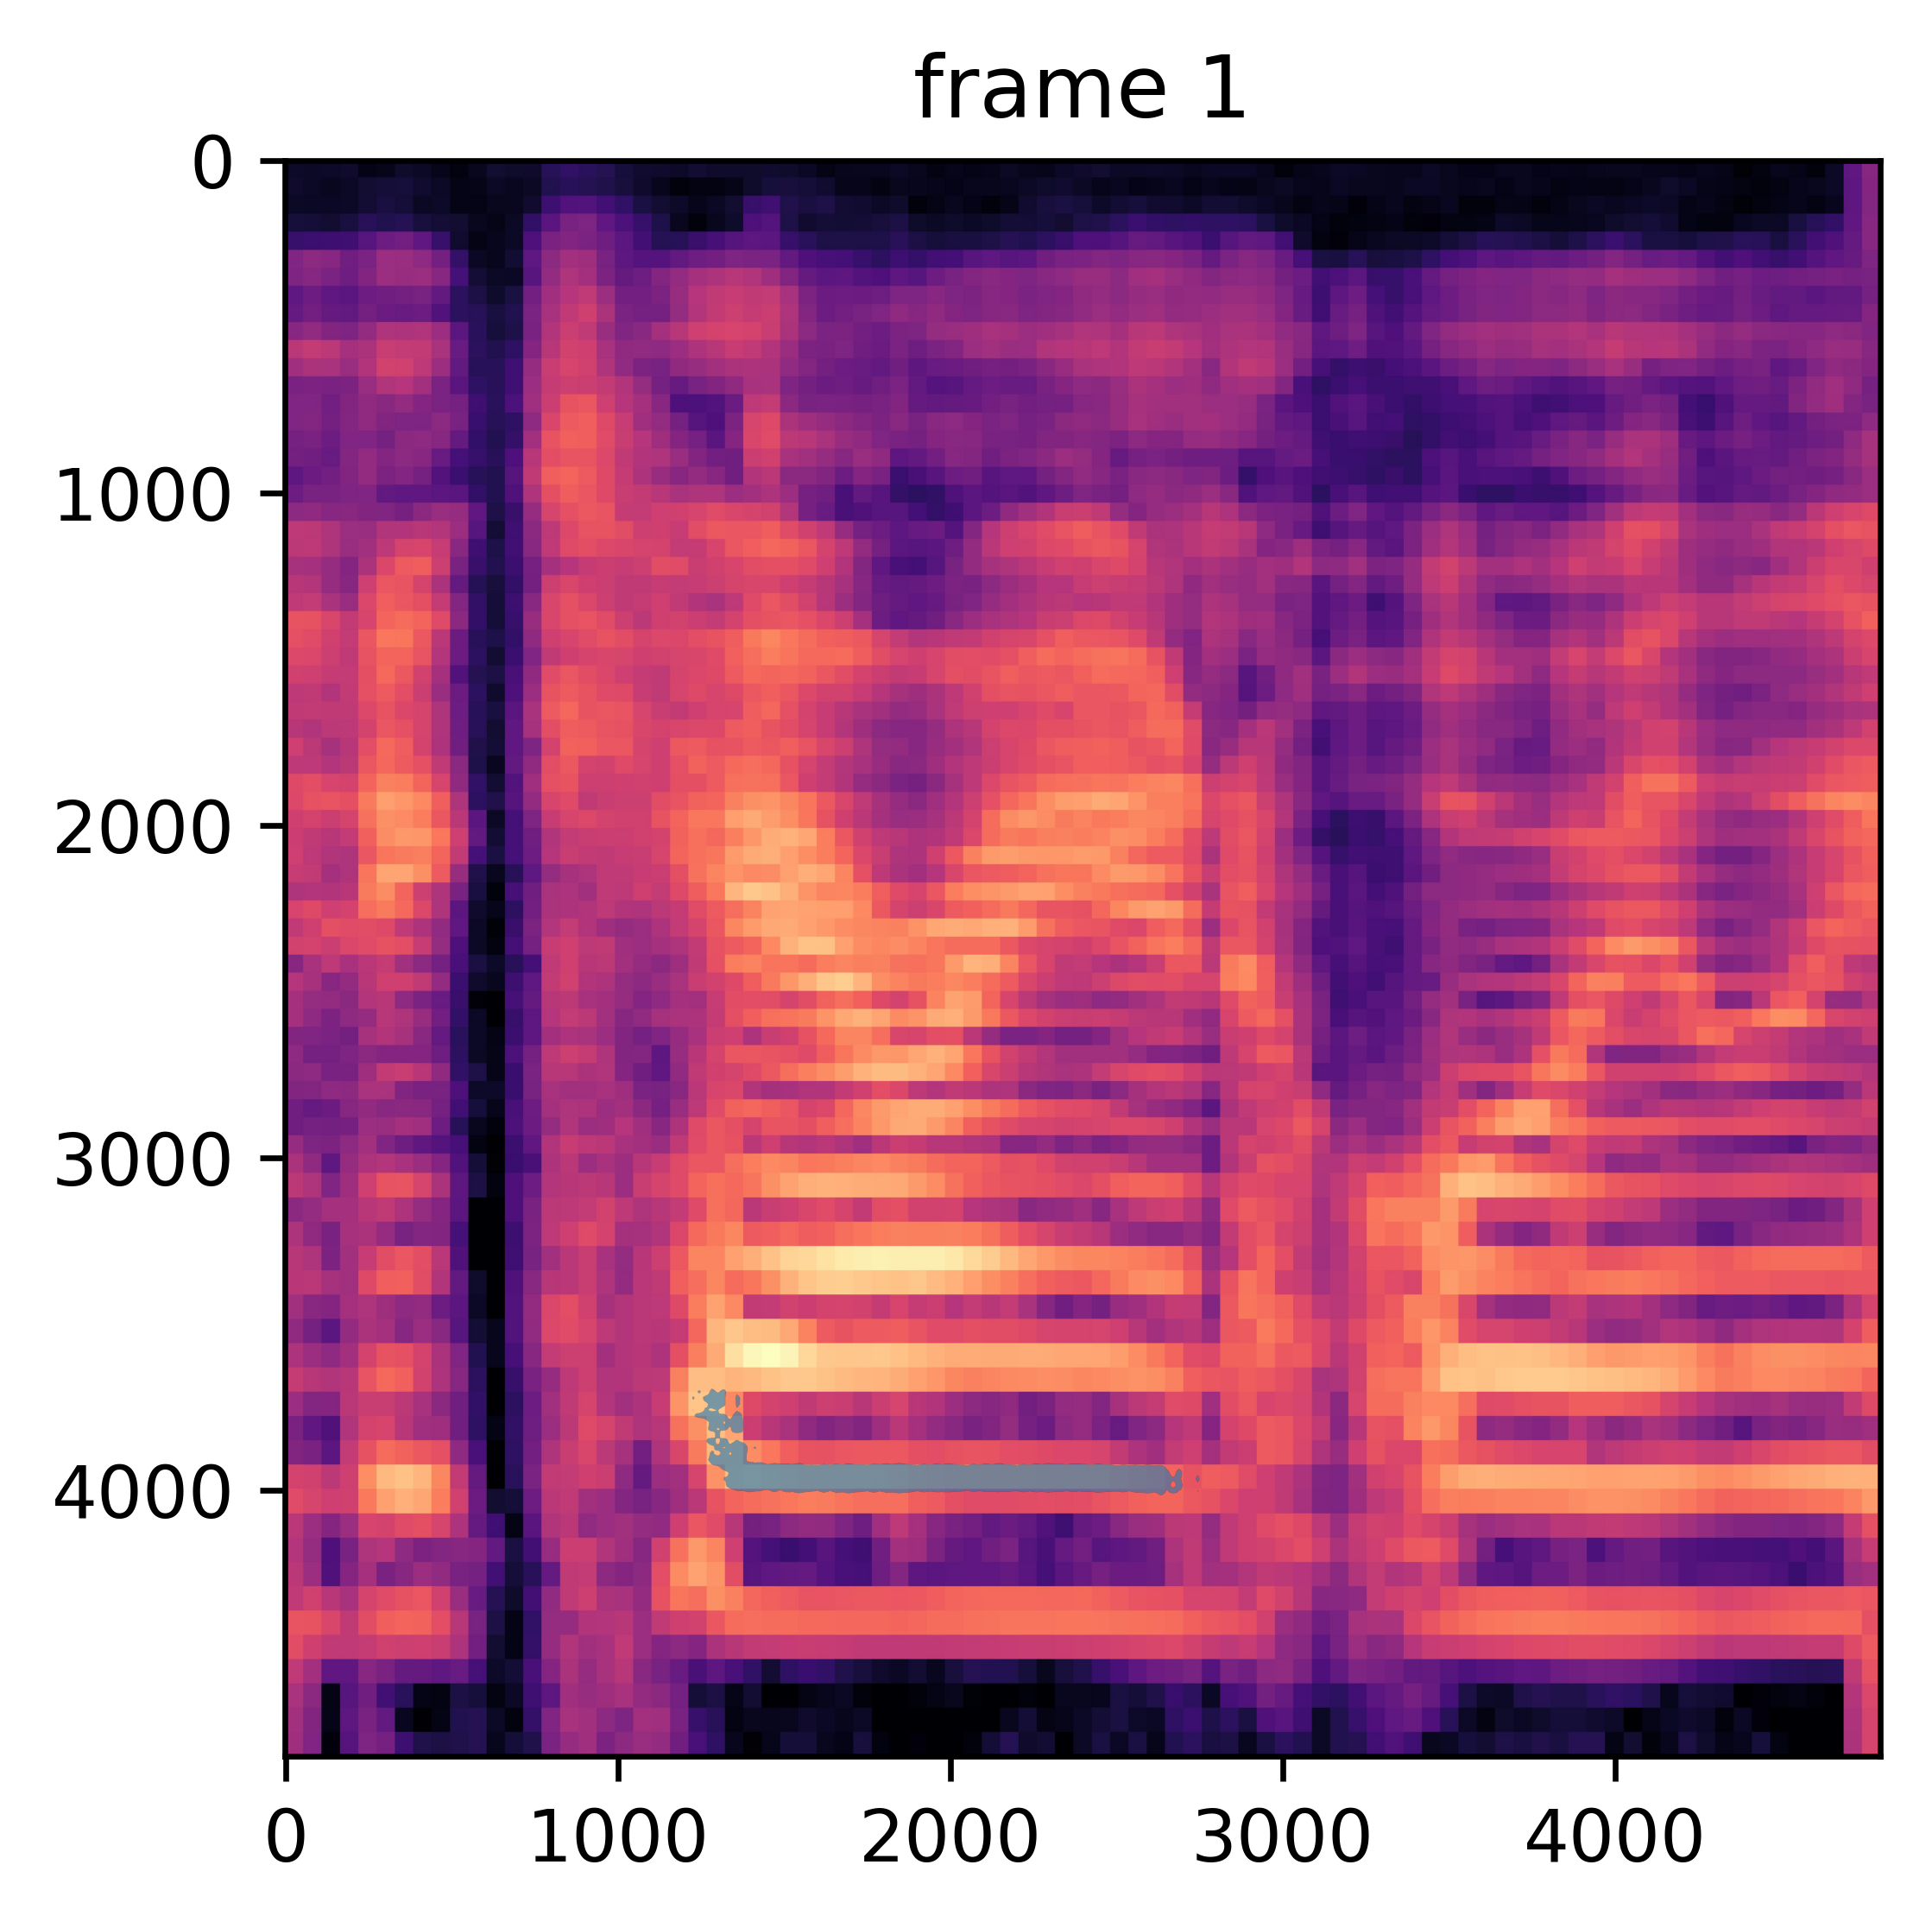

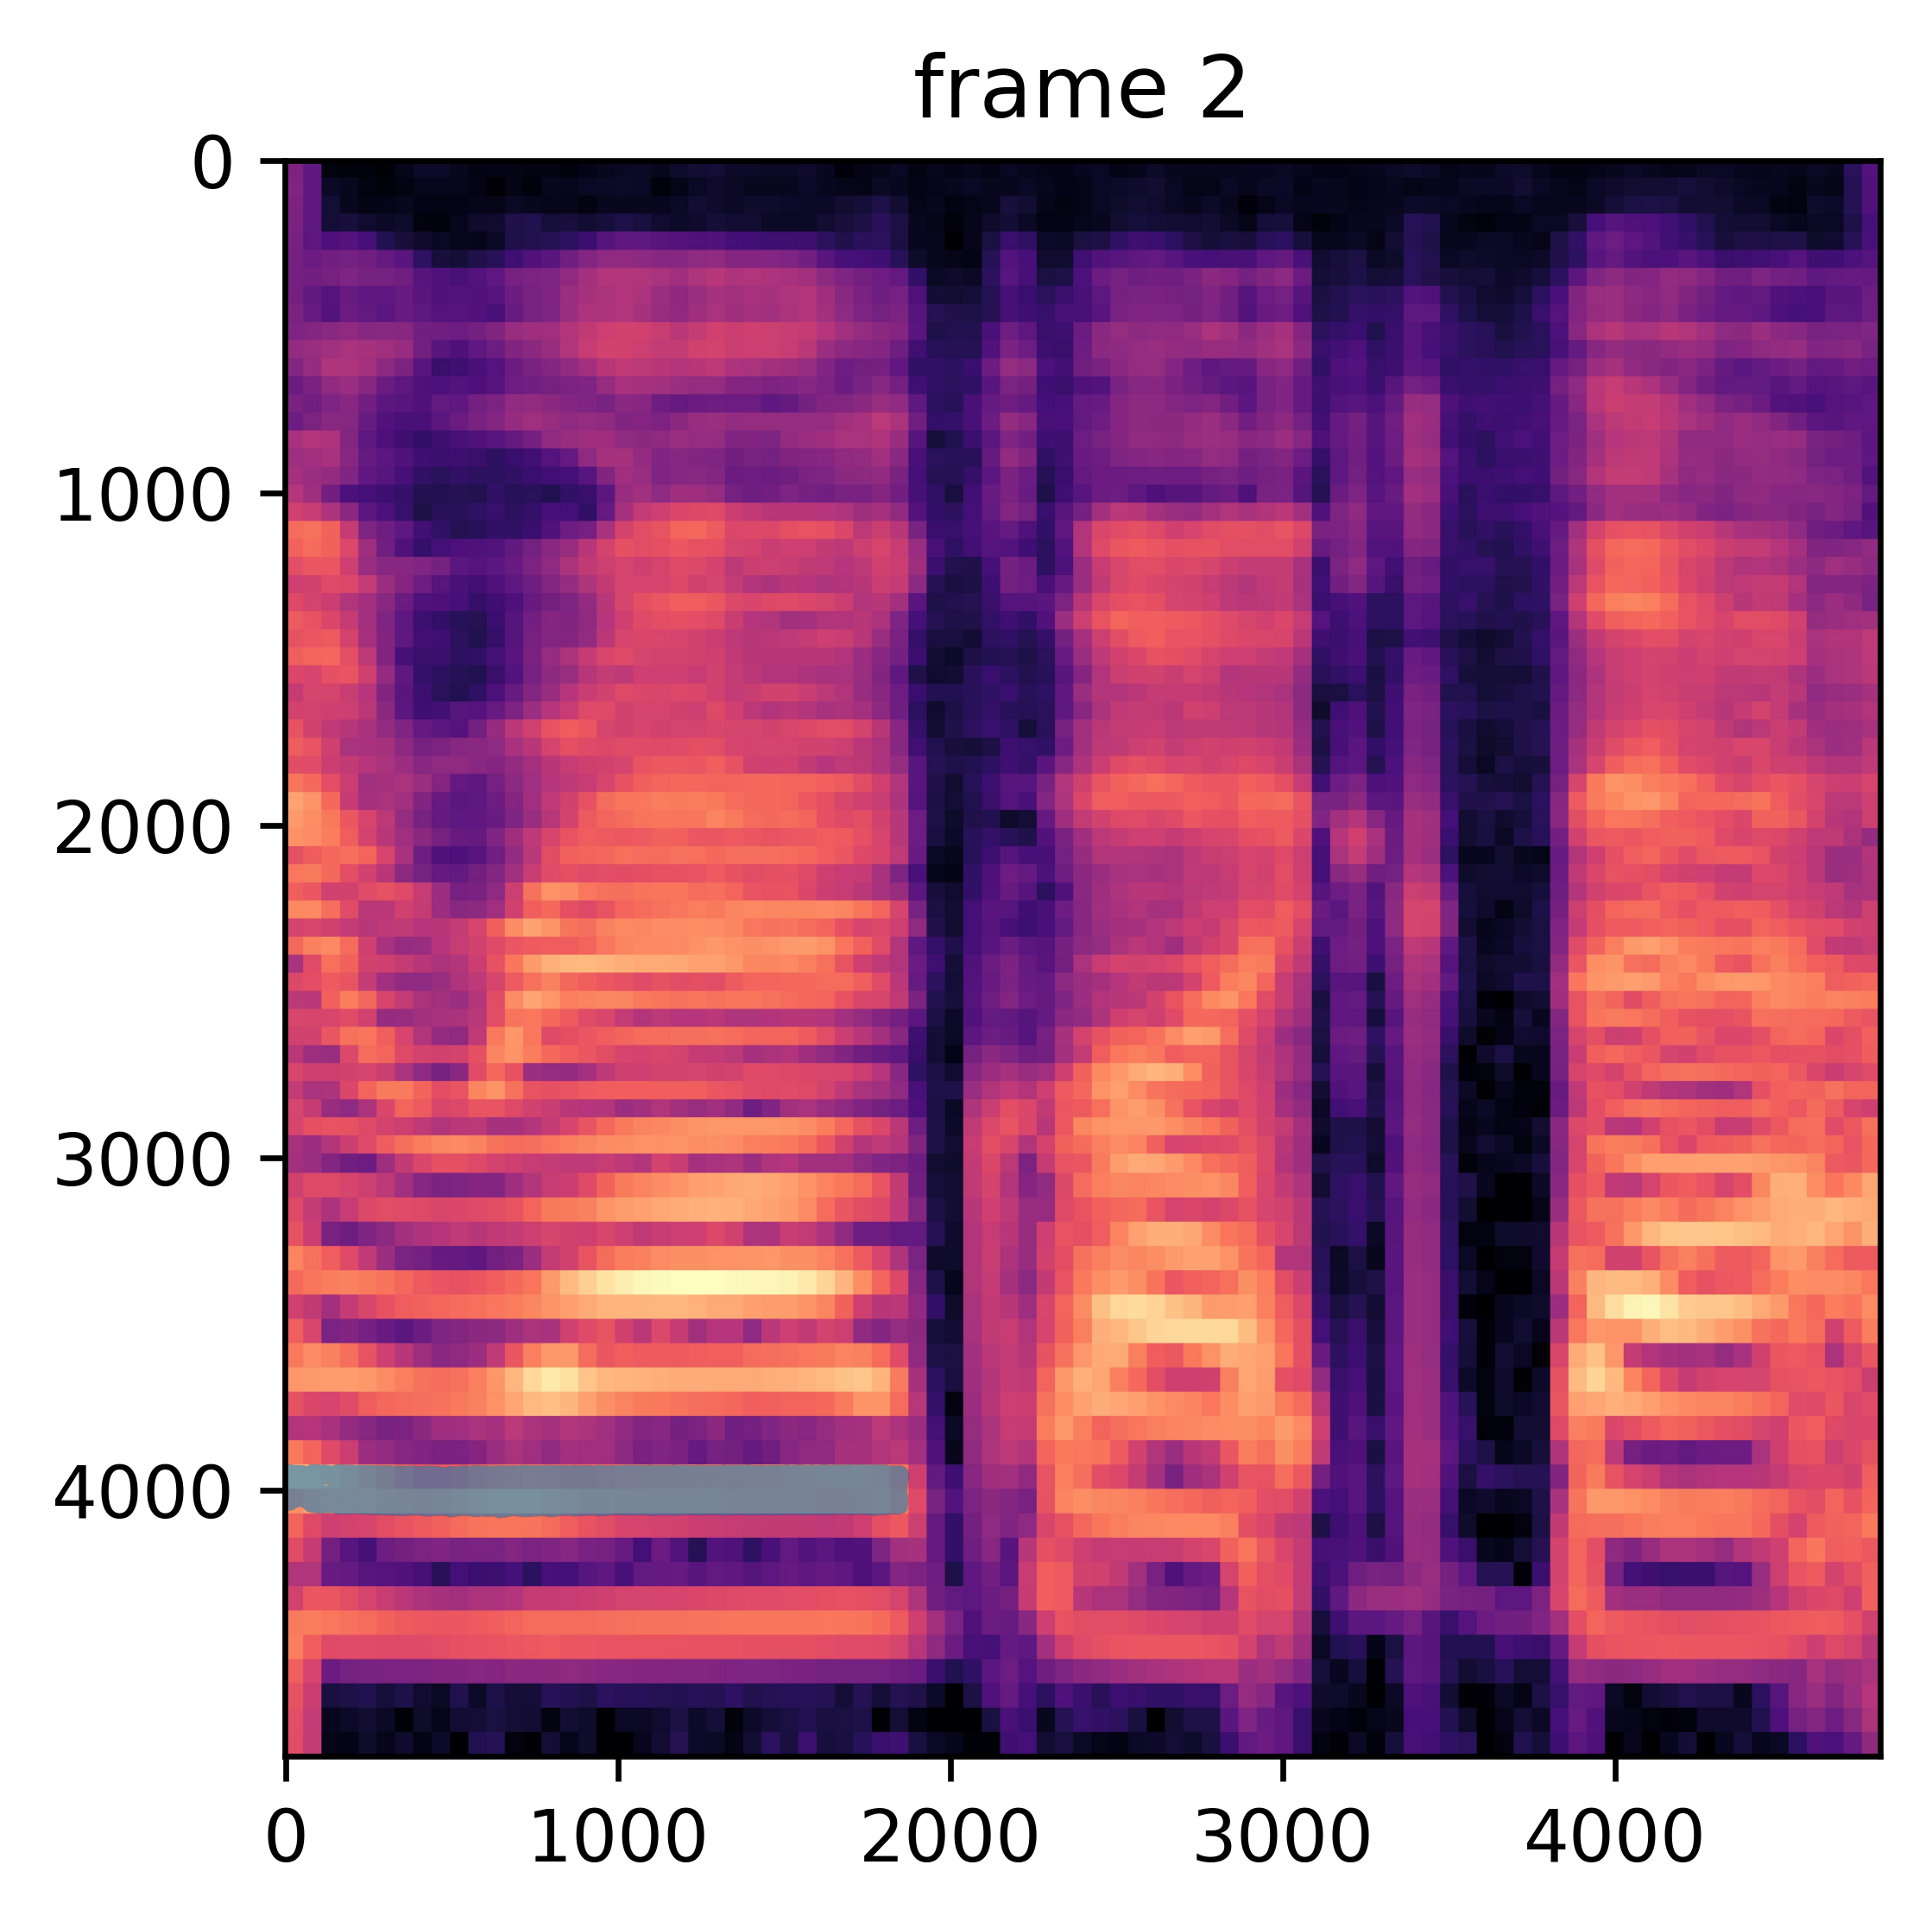

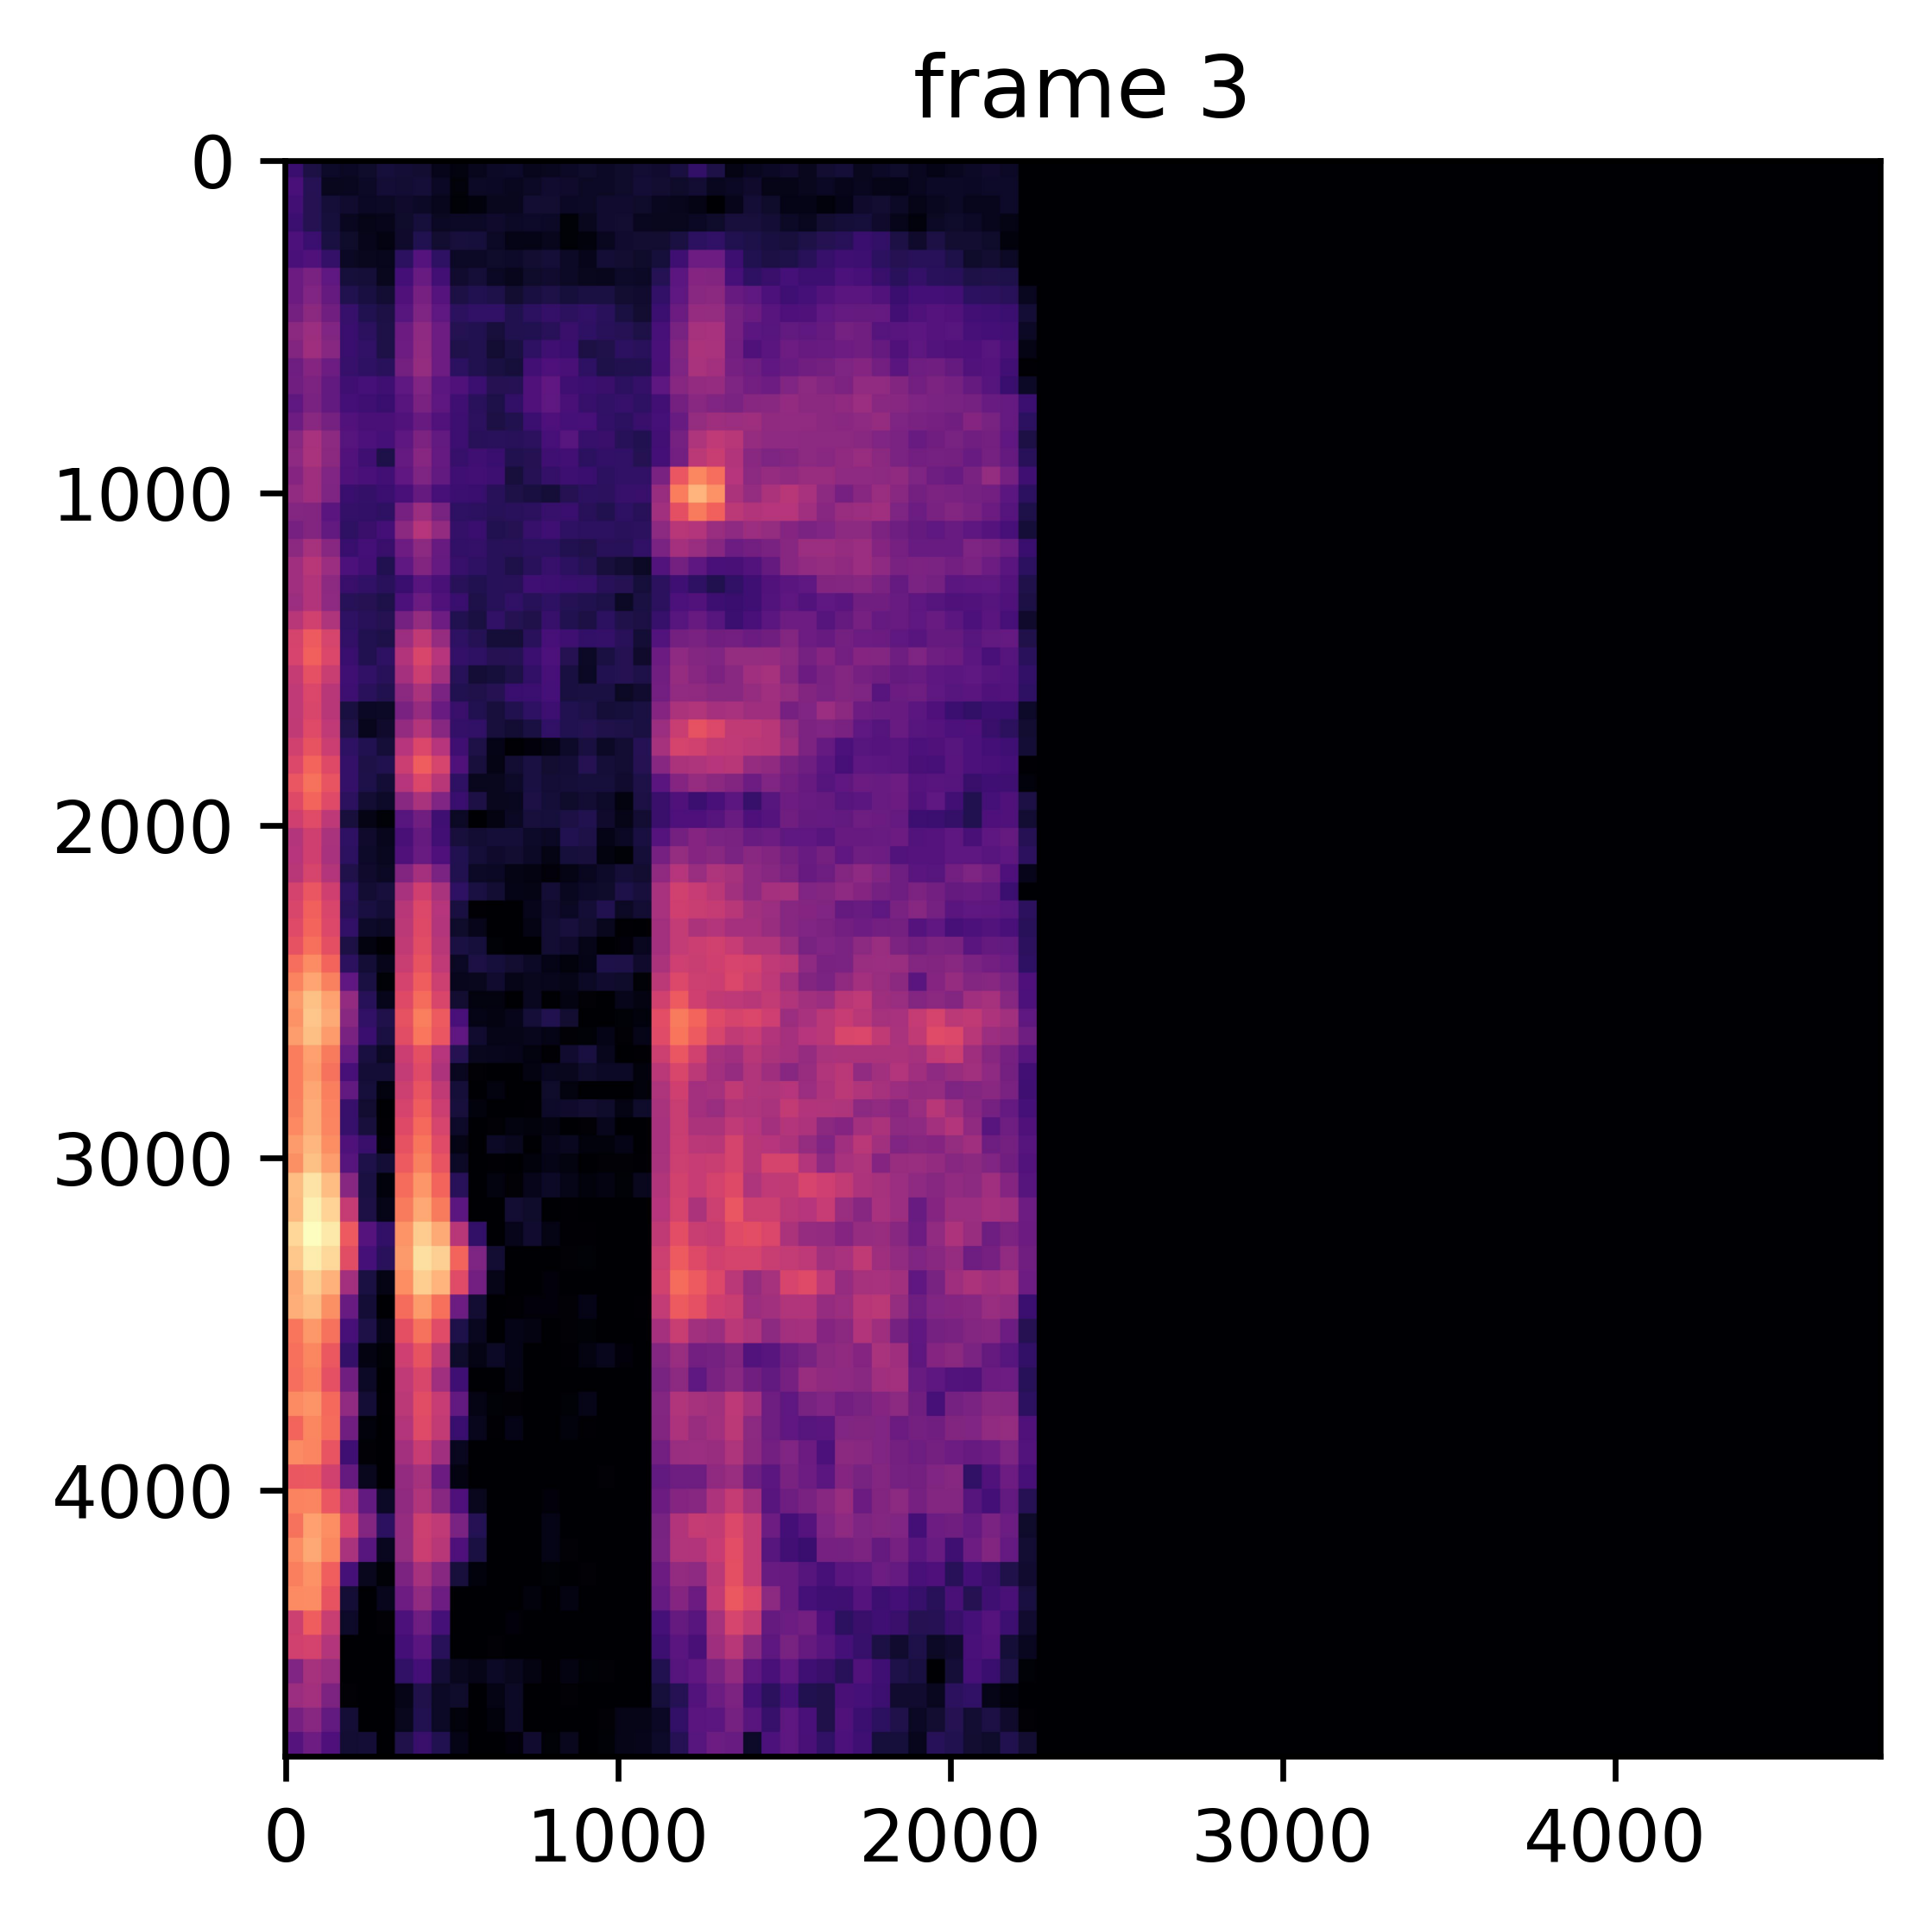

In [15]:
# run propagation throughout the video and collect the results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

# render the segmentation results every few frames
vis_frame_stride = 1 # Should be reduced if the number of frames is large
plt.close("all")
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)

## 4. Applying the masks to the original spectrograms

Now we will fit the mask that sam made to the original spectrogram.


First we will define a function that makes a linear transformation from a position in the image to a position in the spectrogram:

In [16]:
def pixel_to_spectrogram(pixel_x, pixel_y, img_height, img_width, time_bins, freq_bins):
    # Flip y-axis (since images are top-left origin)
    spectrogram_freq_bin = freq_bins - int(pixel_y * freq_bins / img_height) - 1
    spectrogram_time_bin = int(pixel_x * time_bins / img_width)

    # Ensure indices are within bounds
    spectrogram_freq_bin = np.clip(spectrogram_freq_bin, 0, freq_bins - 1)
    spectrogram_time_bin = np.clip(spectrogram_time_bin, 0, time_bins - 1)

    return spectrogram_time_bin, spectrogram_freq_bin

### We will upload the original spectrograms and apply the mask on them:

done


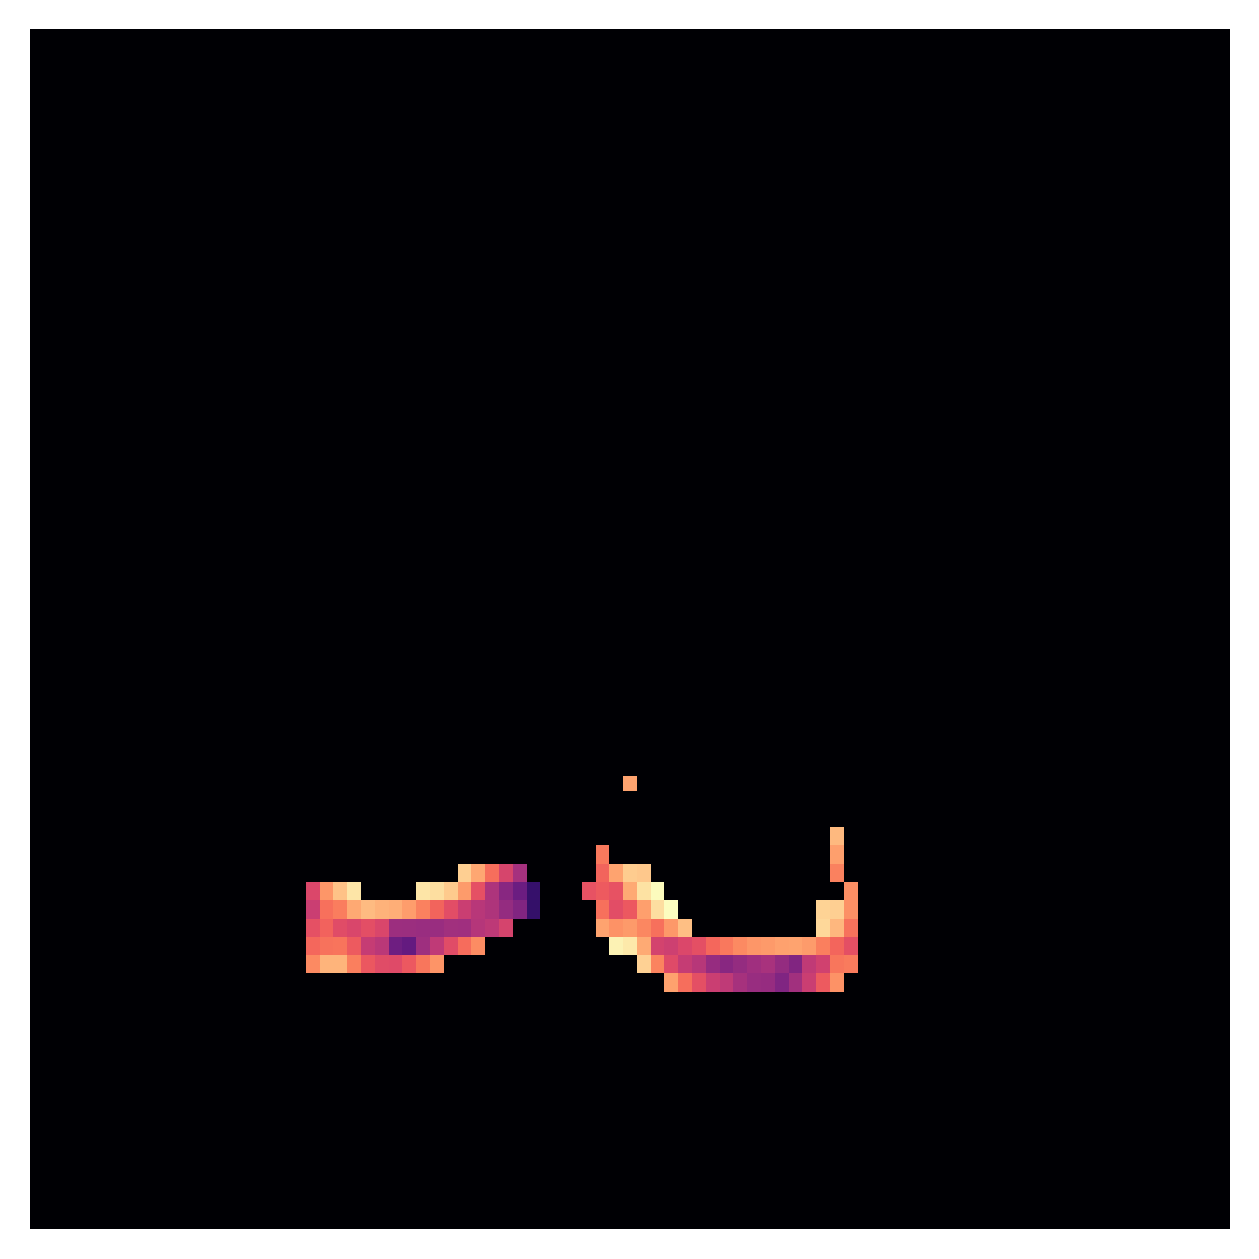

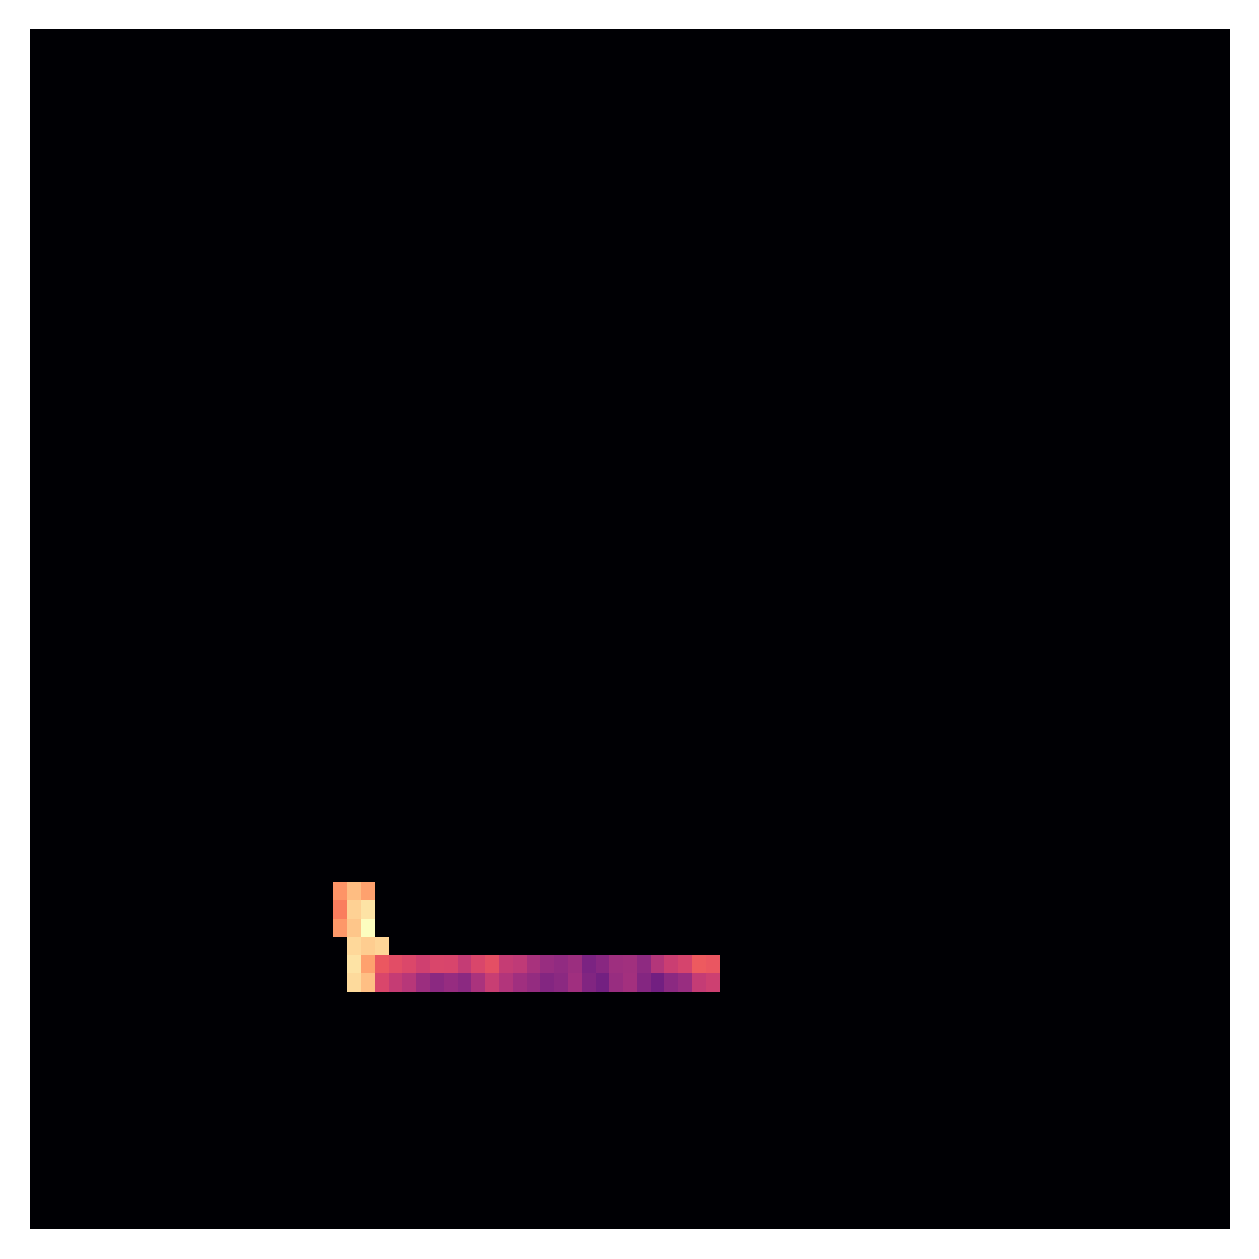

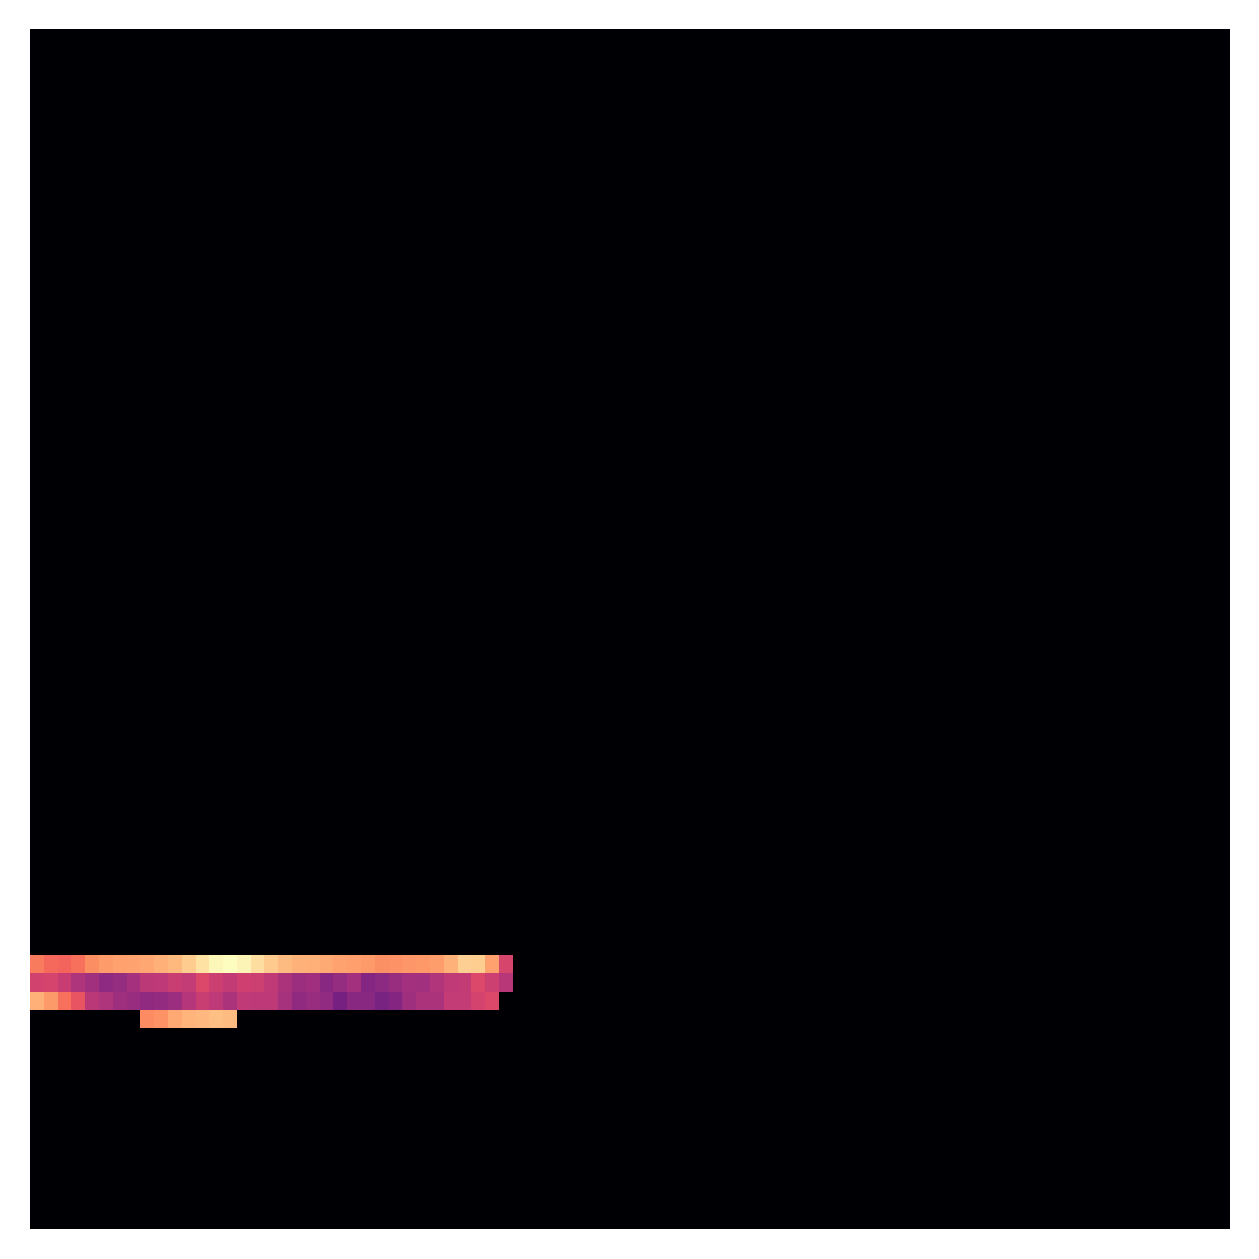

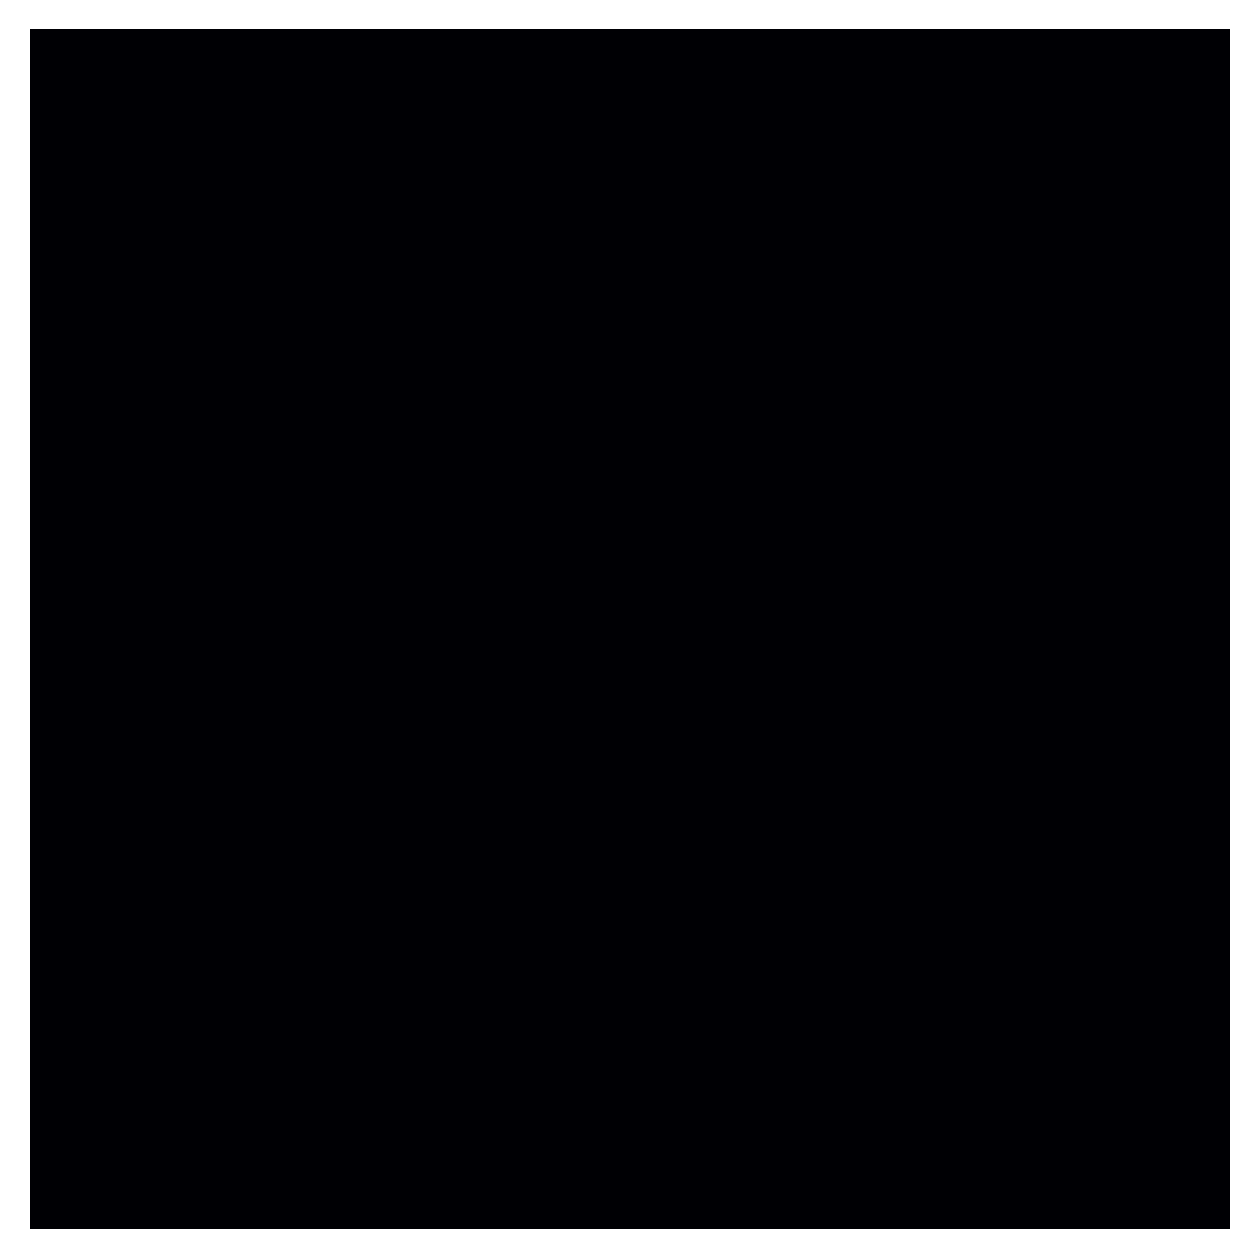

In [17]:
#uplode the original spectogram
output_dir_spec = 'spectrogram_np_array/'

spectogram_names = [
    p for p in os.listdir(output_dir_spec)
    if os.path.splitext(p)[-1] in [".npy"]
]
spectogram_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

maskt_Sxx_full = None
for i in range(0, len(spectogram_names)):
    with open(output_dir_spec + spectogram_names[i], 'rb') as f:
        Sxx = np.load(f)

    # Compute the mapping
    freq_bins, time_bins = Sxx.shape

    inx_list = []
    for j in range(num_of_promt):
        mask = video_segments[i][j][0]
        # Mask dimensions
        mask_height, mask_width = mask.shape
        mask_inx = np.where(mask)
        mask_inx_list = list(zip(mask_inx[1], mask_inx[0]))

        for (x,y) in mask_inx_list:
            a,b = pixel_to_spectrogram(x, y, mask_height, mask_width, time_bins, freq_bins)
            if (a, b) not in inx_list:  # Check if (x, y) is already in the list
                        inx_list.append((a, b))

    mask_to_spec = np.zeros_like(Sxx, dtype=bool)
    for (x,y) in inx_list:
        mask_to_spec[y,x] = True

    maskt_Sxx = Sxx
    maskt_Sxx[~mask_to_spec] = Sxx.min()
    # Plot the spectrogram
    freq_bins, time_bins = maskt_Sxx.shape
    t = np.arange(0, time_bins, 1)
    f = np.arange(0, freq_bins, 1)

    if maskt_Sxx_full is None:
        maskt_Sxx_full = maskt_Sxx
    else:
        maskt_Sxx_full = np.concatenate((maskt_Sxx_full, maskt_Sxx), axis=1)


    # Plot the spectrogram using librosa
    fig = plt.figure(figsize=(4, 4), dpi=300)
    ax = plt.Axes(fig, [0., 0., 1., 1.])  # Remove margins for full screen
    fig.add_axes(ax)
    ax.axis("off")

    librosa.display.specshow(
        maskt_Sxx,
        sr=sr,
        hop_length=overlap,
        x_axis="time",
        y_axis="mel",
        cmap="magma",  # Can try also 'jet'
    )

print("done")

Let's see the final maskt spectrogram

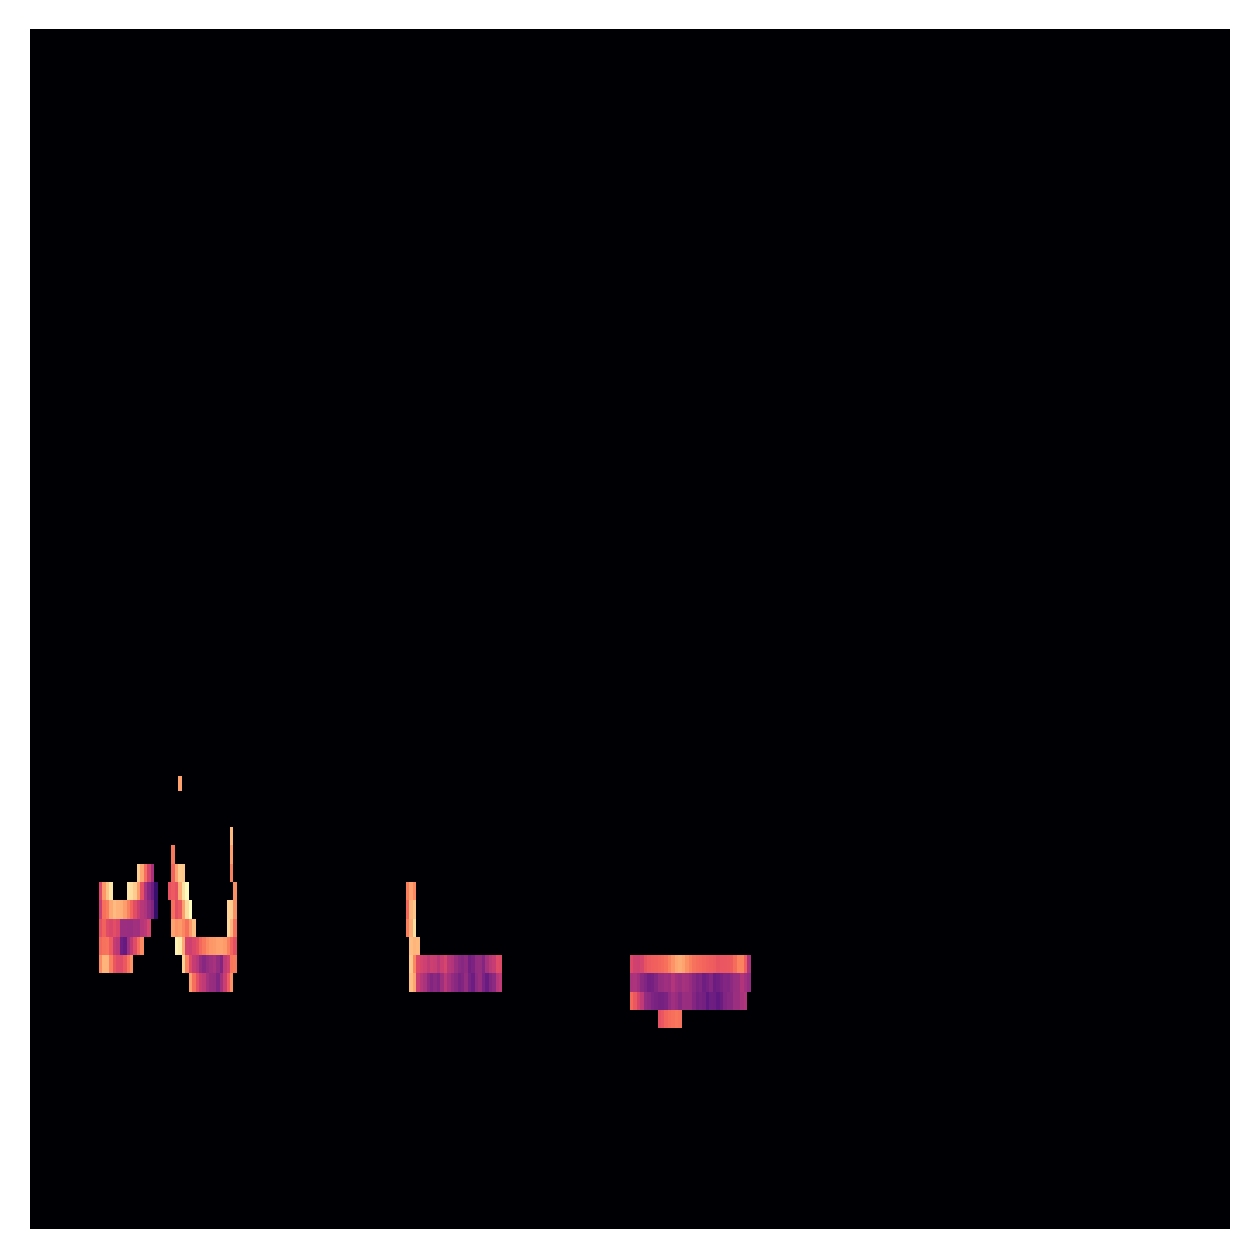

In [18]:
# Plot the spectrogram using librosa
fig = plt.figure(figsize=(4, 4), dpi=300)  # 1024x1024 pixels at 300 DPI
ax = plt.Axes(fig, [0., 0., 1., 1.])  # Remove margins for full screen
fig.add_axes(ax)
ax.axis("off")

librosa.display.specshow(
    maskt_Sxx_full,
    sr=sr,
    hop_length=overlap,
    x_axis="time",
    y_axis="mel",
    cmap="magma",  # Can try also 'jet'
)

# 5. Reconstruction the audio from the maskt spectrograms using DiffWave

In [19]:
# Download DiffWave pre-trained model from - https://github.com/lmnt-com/diffwave/blob/master/README.md
model_dir = r'diffwave-ljspeech-22kHz-1000578.pt' # Change to your directory
print('Mel-Spectrogram to Audio')
mel_spectrogram = torch.tensor(maskt_Sxx_full)
audio, sample_rate = diffwave_predict(mel_spectrogram, model_dir, device=torch.device("cpu"), fast_sampling=True) # device=torch.device('cuda') in case of using GPU

print('Save Reconstructed Audio')
T.save("reconstructed_audio.wav", audio.cpu(), sample_rate=sample_rate)

Mel-Spectrogram to Audio


c:\Users\orita\AppData\Local\Programs\Python\Python311\Lib\site-packages\diffwave\inference.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(mode

FileNotFoundError: [Errno 2] No such file or directory: 'diffwave-ljspeech-22kHz-1000578.pt'

## 6. Play the Reconstructed Audio

In [ ]:
import sounddevice as sd
# Play the audio_resampled
sd.play(audio.squeeze().numpy(), samplerate=sample_rate)

# Wait until playback is finished
sd.wait()